In [1]:
!pip install transformers torch datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [17]:
from datasets import load_dataset
train_dataset=load_dataset('csv',data_files="/content/taskC_train_edited.csv")['train']
eval_dataset=load_dataset('csv',data_files="/content/taskC_eval_edited.csv")['train']

Generating train split: 0 examples [00:00, ? examples/s]

In [18]:
from transformers import BertTokenizer
tokenizer=BertTokenizer.from_pretrained("bert-base-multilingual-cased")
def tokenize_function(examples):
  return tokenizer(examples['tweet'],padding="max_length",truncation=True)
tokenized_train_dataset=train_dataset.map(tokenize_function,batched=True)
tokenized_eval_dataset=eval_dataset.map(tokenize_function,batched=True)

Map:   0%|          | 0/473 [00:00<?, ? examples/s]

In [20]:
from transformers import BertForSequenceClassification,Trainer,TrainingArguments
model_taskC=BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',num_labels=3)
training_args=TrainingArguments(output_dir='./results',eval_strategy="epoch",learning_rate=2e-5,per_device_train_batch_size=16,
                                per_device_eval_batch_size=16,num_train_epochs=5,weight_decay=0.01,save_strategy="epoch")
trainer=Trainer(model=model_taskC,args=training_args,train_dataset=tokenized_train_dataset,eval_dataset=tokenized_eval_dataset)
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,No log
2,No log,No log
3,No log,No log
4,0.664500,No log
5,0.664500,No log


TrainOutput(global_step=690, training_loss=0.5771359650985054, metrics={'train_runtime': 1181.1502, 'train_samples_per_second': 9.33, 'train_steps_per_second': 0.584, 'total_flos': 2899509863362560.0, 'train_loss': 0.5771359650985054, 'epoch': 5.0})

In [21]:
model_taskC.save_pretrained("model_taskc_mBERT_")
tokenizer.save_pretrained("model_taskc_mBERT_")

('model_taskc_mBERT_/tokenizer_config.json',
 'model_taskc_mBERT_/special_tokens_map.json',
 'model_taskc_mBERT_/vocab.txt',
 'model_taskc_mBERT_/added_tokens.json')

In [24]:
import torch

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    # Move input tensors to the same device as the model
    for key in inputs:
        inputs[key] = inputs[key].to(model_taskC.device)

    outputs = model_taskC(**inputs)
    predictions = outputs.logits.argmax(dim=-1)
    return predictions.item()

print(predict("बाबुराम भट्टराईले आफ्नो चुनाव चिह्नमा स्वस्तिक छाप ठोकेर,सबैलाई देखाएको मतपत्र ब्यालेट बाक्समा हालेको फोटोले, लोकतन्त्रको उपहास या उनको बौद्धिक ह्रास मध्ये कुन चाँही होला *****?जय मातृभूमि नेपाल आमाको !धन्ने लोकतान्त्रिक गणतन्त्र को उपलब्धि !!जयश्री पशुपतिनाथ!!!!"))

0


In [3]:
import pandas as pd
test_data=pd.read_csv("/content/taskC_test_edited.csv")

In [4]:
# prompt: use the model_taskC to make predictions on the test_data['tweet'] and add the predictions in the column named prediction_taskC

import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the saved model and tokenizer
model_taskC = BertForSequenceClassification.from_pretrained("/content/mBERT")
tokenizer = BertTokenizer.from_pretrained("/content/mBERT")

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_taskC.to(device)

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    # Move input tensors to the same device as the model
    for key in inputs:
        inputs[key] = inputs[key].to(device)

    with torch.no_grad(): # Disable gradient calculations for inference
        outputs = model_taskC(**inputs)
        predictions = outputs.logits.argmax(dim=-1)
    return predictions.item()

# Make predictions and store them in a new column
predictions_taskC = []
for tweet in test_data['tweet']:
    predictions_taskC.append(predict(tweet))

test_data['prediction_taskC'] = predictions_taskC
print(test_data.head())

   index                                              tweet  truth_label  \
0  50008  सबै मिली सत्रे लाई हराऔँ🙏🙏\n#NoNotAgain \n@cmp...            2   
1  50013  केही बर्षमा कांग्रेस भित्र माओबादी मात्रै बाकी...            1   
2  50017  कस्ता पार्टी सभापति हुन्, हँसियाहथौडामा भाेट न...            0   
3  50018  @prakashgiriji नेपाली जनता श्रीलंकाको जनता बन्...            2   
4  50036  दलबदलुओं को टिकट देने पर मणिपुर बीजेपी में बगा...            0   

   prediction_taskC  
0                 0  
1                 1  
2                 0  
3                 2  
4                 1  


In [7]:

from sklearn.metrics import classification_report
print(classification_report(test_data['truth_label'], test_data['prediction_taskC']))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       226
           1       0.69      0.71      0.70       182
           2       0.36      0.26      0.30        61

    accuracy                           0.67       469
   macro avg       0.58      0.57      0.57       469
weighted avg       0.65      0.67      0.66       469



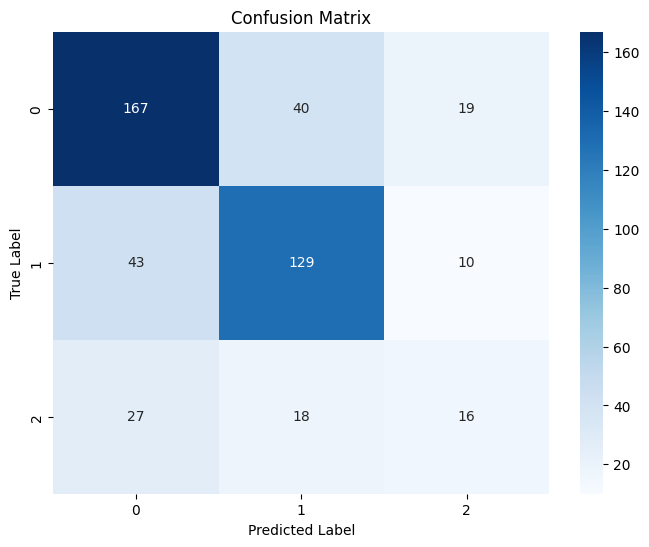

In [8]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_data['truth_label'], test_data['prediction_taskC'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="",
            xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2']) # Assuming labels are 0, 1, 2
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Macro-average ROC AUC score: 0.691464912754554


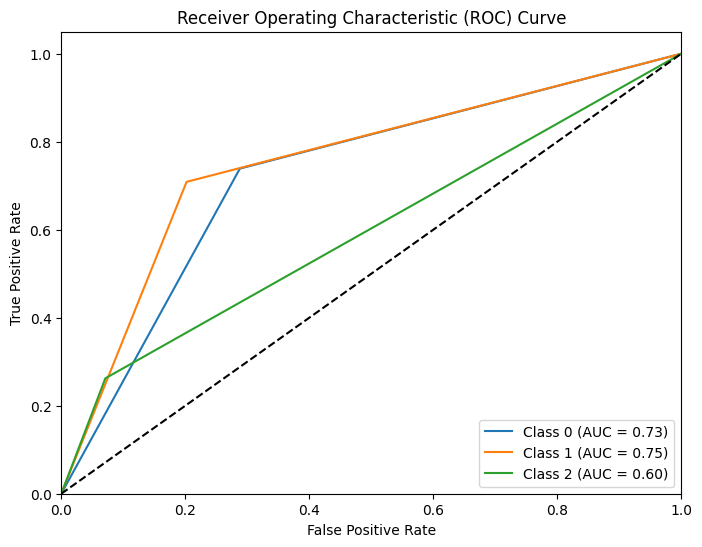

In [9]:
# prompt: plot the PR auc graph

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'truth_label' and 'prediction_taskC' are already defined as in your provided code.

# Convert truth labels to one-hot encoding for multi-class ROC AUC calculation.
from sklearn.preprocessing import label_binarize

y_true = label_binarize(test_data['truth_label'], classes=[0, 1, 2])
y_pred_prob = None  # Placeholder, you'll need to calculate predicted probabilities

if y_pred_prob is None:
    y_pred_prob = np.zeros((len(test_data),3))
    for i in range(len(test_data)):
        y_pred_prob[i,test_data.iloc[i]['prediction_taskC']] = 1.0

# Calculate macro-average ROC AUC score
roc_auc = roc_auc_score(y_true, y_pred_prob, average='macro', multi_class='ovr')
print(f"Macro-average ROC AUC score: {roc_auc}")

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc_per_class = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc_per_class[i] = roc_auc_score(y_true[:,i], y_pred_prob[:,i])


# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc_per_class[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
# prompt: compute overall f1 score

from sklearn.metrics import f1_score

# Assuming 'truth_label' and 'prediction_taskC' are columns in your 'test_data' DataFrame

f1_macro = f1_score(test_data['truth_label'], test_data['prediction_taskC'], average='macro')
print(f"Macro-averaged F1 score: {f1_macro}")

f1_micro = f1_score(test_data['truth_label'], test_data['prediction_taskC'], average='micro')
print(f"Micro-averaged F1 score: {f1_micro}")

f1_weighted = f1_score(test_data['truth_label'], test_data['prediction_taskC'], average='weighted')
print(f"Weighted F1 score: {f1_weighted}")

# F1 scores per class:
f1_per_class = f1_score(test_data['truth_label'], test_data['prediction_taskC'], average=None)
print("F1 score per class:", f1_per_class)

Macro-averaged F1 score: 0.5741520245798651
Micro-averaged F1 score: 0.6652452025586354
Weighted F1 score: 0.6582079408702669
F1 score per class: [0.72138229 0.69918699 0.30188679]
